<span style="font-size:36px"><b>Model Inference</b></span>

Copyright &copy; 2020 Gunawan Lumban Gaol

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language overning permissions and limitations under the License.

# Import Packages

In [1]:
import os
import sys
import glob
import warnings

import numpy as np
import IPython.display as ipd
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
from pydub.utils import mediainfo
from ipywidgets import interact
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model

from gurih.data.splitter import Splitter
from gurih.data.normalizer import AudioNormalizer
from gurih.features.extractor import MFCCFeatureExtractor
from gurih.models.model import BaselineASRModel
from gurih.models.decoder import CTCDecoder
from gurih.models.utils import CharMap

%load_ext autoreload
%autoreload 2

# Load Saved Model

In [2]:
# Configuration file stored in .json
# TODO: read configuration file and create inference Pipeline

In [3]:
model = BaselineASRModel(input_shape=(3000, 39), vocab_len=29, training=False)  # pass false to not save model config
model.compile()

Model directory is set to ../../models/
Documentation directory is set to ../../docs/

Model: "BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 3000, 39)]        0         
_________________________________________________________________
masking (Masking)            (None, 3000, 39)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1495, 200)         86000     
_________________________________________________________________
bidirectional (Bidirectional (None, 1495, 400)         641600    
_________________________________________________________________
the_output (TimeDistributed) (None, 1495, 30)          12030     
Total params: 739,630
Trainable params: 739,630
Non-trainable params: 0
_________________________________________________________

In [4]:
filename = os.path.abspath("../../models/Model010b/BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29.h5") # must provide abs path
model.load(filename)


Loaded model D:\Data Science Academy (2)\voice-to-text-bahasa\models\Model010b\BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29.h5 from disk.


# Create Audio Transcript

In [5]:
# Single file
# mp3_file = "blabla.mp3"
# X = [mp3_file]

In [6]:
# Multiple files from a directory
input_dir = "../../dataset/sample/"
mp3_files = glob.glob(input_dir+"*.mp3")
X = mp3_files
print(f"Total audio files: {len(X)}")

Total audio files: 11


In [41]:
X

['../../dataset/sample\\2019-09-03_Annisa Rahmawaty_3903350662_INT.mp3',
 '../../dataset/sample\\20190807_3902961838_Putri Despita_PTS.mp3',
 '../../dataset/sample\\20190819_3903089815_Muhamad Iqbal_PTS.mp3',
 '../../dataset/sample\\20190904_3900300934_Denny Fauzi_ NI.mp3',
 '../../dataset/sample\\20190905_3903379373_Noni Simangunsong_INT.mp3',
 '../../dataset/sample\\20190905_3903384721_Eva Suryaningsih.mp3',
 '../../dataset/sample\\202102_1.mp3',
 '../../dataset/sample\\239382.mp3',
 '../../dataset/sample\\Agung Ibrahim_85363151864_3903181630_20190821_INT.mp3',
 '../../dataset/sample\\CRS_M4_RTP_11766328359.mp3',
 '../../dataset/sample\\CRS_PreDD_PTP_11750082079.mp3']

Create transcription from input audio by following steps:
1. If channels > 1, split audio files into each channel
2. For each channel, if audio `frames > max_seq_length` then the audio will be splitted before transcription

In [42]:
x = np.array([X[1]])

# Test Mono

In [35]:
sr = 16000

In [36]:
# Test mono audio
normalizer = AudioNormalizer(sample_rate=sr,
                             mono=True,
                             write_audio_output=False, # don't output normalized audio
                             output_dir="",
                             encode=False) # don't output .json
x_norm = normalizer.fit_transform(x)

(1, 3209927)

Perform next process for each channel.

In [37]:
for x_c in x_norm[0]:  # on each channel
    x_c = np.expand_dims(x_c, axis=0)
    print(x_c.shape)
    splitter = Splitter(max_frame_length=16000*30+81,
                        strides=16000*30+81,
                        padding='same',
                        low_memory=False)
    x_splitted = splitter.fit_transform(x_c)
    print(x_splitted.shape)
    
    
    mfcc_extractor = MFCCFeatureExtractor(sample_rate=sr,
                                      frame_size=0.025,
                                      frame_stride=0.01,
                                      filter_num=26,
                                      cep_num=13,
                                      NFFT=512,
                                      low_freq=0,
                                      high_freq=None,
                                      pre_emphasis_coeff=0.97,
                                      cep_lifter=22,
                                      dct_type=2,
                                      dct_norm="ortho",
                                      append_energy=True,
                                      append_delta=True,
                                      low_memory=False,
                                      write_output=False,
                                      output_dir=".")

    x_freq = mfcc_extractor.fit_transform(x_splitted[0])
    print(x_freq.shape)
    
    ctc_matrix = model.predict(x_freq, low_memory=False)
    print(ctc_matrix.shape)
    decoder = CTCDecoder(CharMap.IDX_TO_CHAR_MAP)
    decoder.fit(ctc_matrix)
    y_pred = decoder.predict(ctc_matrix)
    print(y_pred)

(1, 3209927)
(1, 7, 480081)
(7, 3000, 39)
(7, 1495, 30)
['', '', 'a', '', '', '', '']


# Test Stereo

In [116]:
sr = 16000

In [117]:
# Test mono audio
normalizer = AudioNormalizer(sample_rate=sr,
                             mono=False,
                             write_audio_output=False, # don't output normalized audio
                             output_dir="",
                             encode=False) # don't output .json
x_norm = normalizer.fit_transform(x)
x_norm[0].shape

(2, 2097216)

(1, 2097216)
(1, 5, 480081)
(1, 3000, 39)
(1, 3000, 39)
(1, 3000, 39)
(1, 3000, 39)
(1, 3000, 39)
(5, 3000, 39)
(5, 1495, 30)
['', '', '', 'g', '']


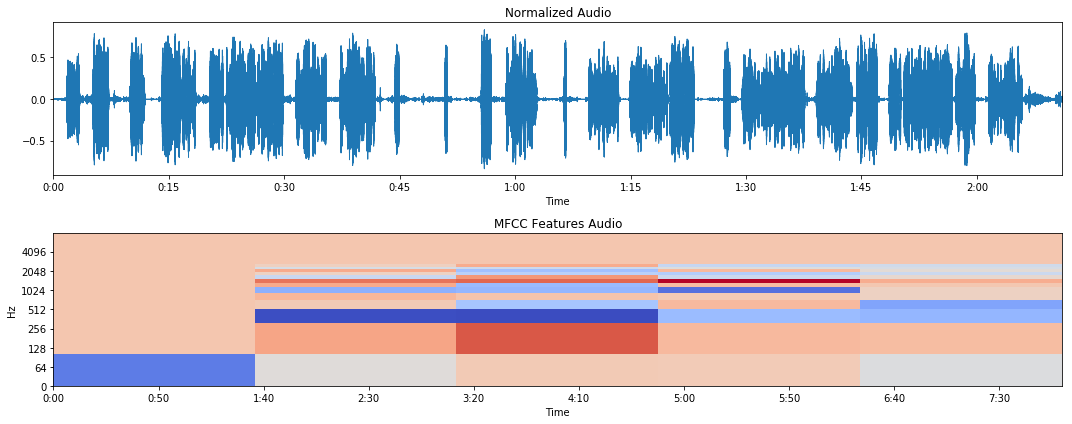


(1, 2097216)
(1, 5, 480081)
(1, 3000, 39)
(1, 3000, 39)
(1, 3000, 39)
(1, 3000, 39)
(1, 3000, 39)
(5, 3000, 39)
(5, 1495, 30)
['', '', '', '', '']


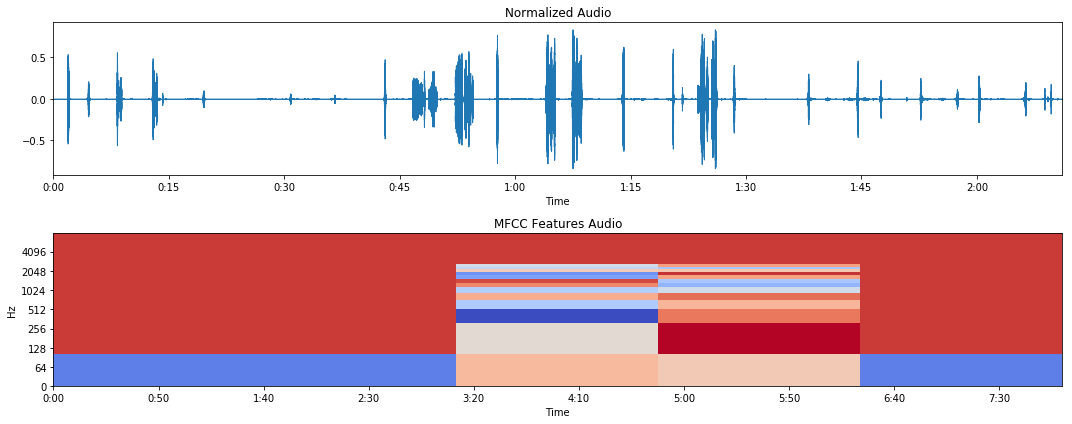

In [126]:
for x_c in x_norm[0]:  # on each channel
    x_c = np.expand_dims(x_c, axis=0)
    print(x_c.shape)
    splitter = Splitter(max_frame_length=16000*30+81,
                        strides=16000*30+81,
                        padding='same',
                        low_memory=False)
    x_splitted = splitter.fit_transform(x_c)
    print(x_splitted.shape)
    
    x_freqs = []
    for split in x_splitted[0]:
        split = np.expand_dims(split, axis=0)
        mfcc_extractor = MFCCFeatureExtractor(sample_rate=sr,
                                              frame_size=0.025,
                                              frame_stride=0.01,
                                              filter_num=26,
                                              cep_num=13,
                                              NFFT=512,
                                              low_freq=0,
                                              high_freq=None,
                                              pre_emphasis_coeff=0.97,
                                              cep_lifter=22,
                                              dct_type=2,
                                              dct_norm="ortho",
                                              append_energy=True,
                                              append_delta=True,
                                              low_memory=False,
                                              write_output=False,
                                              output_dir=".")

        x_freq = mfcc_extractor.fit_transform(split)
        x_freqs.extend(x_freq)
        print(x_freq.shape)
    x_freqs = np.array(x_freqs)
    print(x_freqs.shape)
    
    ctc_matrix = model.predict(x_freqs, low_memory=False)
    print(ctc_matrix.shape)
    decoder = CTCDecoder(CharMap.IDX_TO_CHAR_MAP)
    decoder.fit(ctc_matrix)
    y_pred = decoder.predict(ctc_matrix)
    print(y_pred)
    
    # Create figure for visualization
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    _ = ld.waveplot(np.asfortranarray(x_c), sr=sr)
    plt.title("Normalized Audio")
    plt.subplot(2, 1, 2)
    _ = ld.specshow(x_freqs.reshape(-1, 39).T, sr=sr, x_axis='time', y_axis='log')
#     _ = ld.specshow(x_freq[0].T, sr=sr, x_axis='time', y_axis='log')
    plt.title("MFCC Features Audio")
    plt.tight_layout()
    plt.show()
    print()

In [17]:
def infer(x, model, sr=16000, force_mono=False):
    """
    Given input audio frames, generate transcription string.
    
    Parameters
    ----------
    x : np.array[shape=(m,)]
        audio input filename
    model : gurih.models.model.BaselineASRModel
        instance of "trained" ASRModel with predict method returning CTC matrix.
    sr : int, [default=16000]
        sample rate of audio files, equal to sequence_length divided by audio
        duration
    force_mono : bool, [default=False]
        if True, for mono processing even for audio with channel more than 1
    
    Returns
    -------
    y_pred : str,
        prediction string of given input audio sequence
    """
    if int(mediainfo(x)['channels']) > 1:
        if force_mono is True:
            normalizer = AudioNormalizer(sample_rate=sr,
                                         mono=True,
                                         write_audio_output=False, # don't output normalized audio
                                         output_dir="",
                                         encode=False) # don't output .json
            x_norm = normalizer.fit_transform(x)
            print(x_norm.shape)
            x_freq = mono_process(x_norm, sr)
        else:
            warnings.warn("Performing channel split and transcripting for each channel. "\
                           "You can force mono process by passing force_mono=True.")
            normalizer = AudioNormalizer(sample_rate=sr,
                                         mono=False,
                                         write_audio_output=False, # don't output normalized audio
                                         output_dir="",
                                         encode=False) # don't output .json
            x_norm = normalizer.fit_transform(x)
            print(x_norm.shape)
            return
            # Process for each channel
            x_freq = []
            for x_c in x_norm[0]:
                x_f = mono_process(x_c, sr)
                x_freq.append(x_f)
    else:
        normalizer = AudioNormalizer(sample_rate=sr,
                                     mono=True,
                                     write_audio_output=False, # don't output normalized audio
                                     output_dir="",
                                     encode=False) # don't output .json
        x_norm = normalizer.fit_transform(x)
        x_freq = mono_process(x_norm, sr)
    
    for x in x_freq:
        ctc_matrix = model.predict(x_freq, low_memory=True)
        decoder = CTCDecoder(CharMap.IDX_TO_CHAR_MAP)
        decoder.fit(ctc_matrix)
        y_pred = decoder.predict(ctc_matrix)
        print(y_pred)
    
    return y_pred

In [18]:
def mono_process(x_norm, sr=16000, plot=True):
    """
    Process a channel from given audio input filename.
    
    Parameters
    ----------
    x_norm : numpy.ndarray[shape=(sequence_length, )]
        loaded and normalized audio input sequence
    sr : int, [default=16000]
        sample rate of audio files, equal to sequence_length divided by audio
        duration
    plot : bool, [default=True]
        wether to plot audio wave and its processes
        
    Returns
    -------
    x_freq : numpy.ndarray[shape=(o, max_frame_length, mfcc_features)]
        mfcc features of given input audio sequence. 'o' is the number of
        splitted audio equals to floor(sequence_length // max_frame_length)
    """
    if x_norm.ndim == 1:
        x_norm = np.expand_dims(x_norm, axis=0)

    # Split audio
    splitter = Splitter(max_frame_length=16000*30+81,
                        strides=16000*30+81,
                        padding='same',
                        low_memory=False)
    x_splitted = splitter.fit_transform(x_norm)
    
    print(x_splitted.shape)
    # Extract MFCC Features
    for x_chunk in x_splitted:
        mfcc_extractor = MFCCFeatureExtractor(sample_rate=sr,
                                              frame_size=0.025,
                                              frame_stride=0.01,
                                              filter_num=26,
                                              cep_num=13,
                                              NFFT=512,
                                              low_freq=0,
                                              high_freq=None,
                                              pre_emphasis_coeff=0.97,
                                              cep_lifter=22,
                                              dct_type=2,
                                              dct_norm="ortho",
                                              append_energy=True,
                                              append_delta=True,
                                              low_memory=True,
                                              write_output=False,
                                              output_dir=".")

        x_freq = mfcc_extractor.fit_transform(x_splitted)    

    # Create figure for visualization
    if plot is True:
        plt.figure(figsize=(15, 6))
        plt.subplot(2, 1, 1)
        _ = ld.waveplot(np.asfortranarray(x_norm), sr=sr)
        plt.title("Normalized Audio")
        plt.subplot(2, 1, 2)
        _ = ld.specshow(x_freq, sr=sr)
        plt.title("MFCC Features Audio")
        plt.show()
    
    return x_freq

In [11]:
@interact
def plot_sample(x=X):
    data, sr = librosa.load(x, mono=False, sr=22050)
    plt.figure(figsize=(12, 7))
    plt.subplot(3, 1, 1)
    _ = librosa.display.waveplot(data, sr=sr)
    plt.title(x)
    plt.subplot(3, 1, 2)
    _ = librosa.display.waveplot(np.asfortranarray(data[0]), sr=sr)
    plt.title("Operator Side")
    plt.subplot(3, 1, 3)
    _ = librosa.display.waveplot(np.asfortranarray(data[1]), sr=sr)
    plt.title("Client Side")
    plt.tight_layout()
    plt.show()
    return ipd.Audio(x)

interactive(children=(Dropdown(description='x', options=('../../dataset/sample\\202102_1.mp3',), value='../../…